# Proyecto 2: Modelo de predicción BERT
|      Nombre     | Carnet |
|:---------------:|:------:|
| André Rodríguez |  18332 |
|   Cesar Rodas   |  16776 |
|  Javier Ramirez |  18099 |
|  Abril Palencia |  18198 |

## Importación de librerías

In [45]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd

## Carga de archivos

Se carga el archivo clean_data.csv, el cual se encuentra ya procesado y contiene la siguiente informacion:
- text: texto del tweet preprocesado
- target: 1 (Tweet de desastre) o 0 (tweet de no desastre)

In [8]:
data = pd.read_csv("../clean_data.csv")
data.head(5)

,keyword,location,text,target
0,None,None,deeds reason earthquake may allah forgive us,1
1,None,None,forest fire near ronge sask canada,1
2,None,None,residents asked shelter place notified officer...,1
3,None,None,people receive wildfires evacuation orders cal...,1
4,None,None,got sent photo ruby alaska smoke wildfires pou...,1


In [9]:
data.groupby('target').describe()

keyword                          location                     text  \
         count unique          top freq    count unique   top  freq count   
target                                                                      
0         4342    219  body%20bags   40     4342   2143  None  1458  4315   
1         3271    221         None   42     3271   1514  None  1075  3247   

                                                                       
       unique                                                top freq  
target                                                                 
0        4261  black eye space battle occurred star involving...    8  
1        3179  yearold boy charged manslaughter toddler repor...   10

In [13]:
data_one = data[data['target']==1]
data_one.shape

(3271, 4)

In [14]:
data_zero = data[data['target']==0]
data_zero.shape

(4342, 4)

## Separación de datos

In [52]:
data_zero_downsampled_X, data_zero_downsampled_Y = data_zero.text.sample(data_one.shape[0]).fillna(' '), data_zero.target.sample(data_one.shape[0]).fillna(int(0))
data_one_X, data_one_Y = data_one.text.fillna(' '), data_one.target.fillna(int(0))

data_zero_downsampled_X = data_zero_downsampled_X.to_numpy()
data_one_X = data_one_X.to_numpy()

data_zero_downsampled_Y = data_zero_downsampled_Y.to_numpy()
data_one_Y = data_one_Y.to_numpy()

In [69]:
X_train = np.concatenate((data_zero_downsampled_X[:int(len(data_zero_downsampled_X)*0.8)], data_one_X[:int(len(data_one_X)*0.8)]))
X_test = np.concatenate((data_zero_downsampled_X[int(len(data_zero_downsampled_X)*0.7):], data_one_X[int(len(data_one_X)*0.7):]))

Y_train = np.concatenate((data_zero_downsampled_Y[:int(len(data_zero_downsampled_Y)*0.8)], data_one_Y[:int(len(data_one_Y)*0.8)]))
Y_test = np.concatenate((data_zero_downsampled_Y[int(len(data_zero_downsampled_Y)*0.7):], data_one_Y[int(len(data_one_Y)*0.7):]))

## Formación del modelo

In [22]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


In [30]:
# Bert Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#Neural network Layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# Final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'pooled_output': (N 109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [32]:
METRICAS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICAS)

## Entrenamiento y Testeo del modelo

In [47]:
model.fit(X_train, Y_train, epochs=10)

Epoch 1/10
164/164 [==============================] - 761s 5s/step - loss: 0.6770 - accuracy: 0.5812 - precision: 0.5813 - recall: 0.5810

In [56]:
labels = model.predict(X_test)

In [61]:
labels = labels.flatten()

In [62]:
labels = np.where(labels > 0.5, 1, 0)
labels

array([0, 1, 0, ..., 1, 1, 1])

## Resultados

In [71]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(Y_test,labels)
mat

array([[810, 172],
       [277, 705]], dtype=int64)

Text(33.0, 0.5, 'Truth')

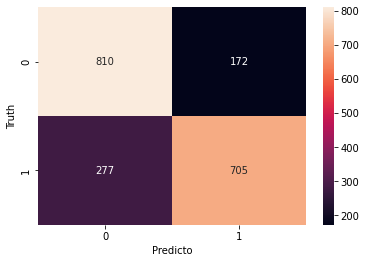

In [73]:
from matplotlib import pyplot as plt
import seaborn as sn

sn.heatmap(mat, annot=True, fmt='d')
plt.xlabel('Predicto')
plt.ylabel('Truth')

## Función para la predicción con tweets

In [83]:
def predict_category(s,train=Y_train,mode=model):
    pred=mode.predict([s])
    print("Prediction: "+str(round(pred[0][0])))
    print("\tDisaster Tweet") if round(pred[0][0]) == 1 else print("\tNon Disaster Tweet")

In [86]:
predict_category("theres emergency evacuation happening building across street")

Prediction: 1
	Disaster Tweet
